In [1]:
%cd /raid6/home/yokoyama/cfm_for_activity_recognition
import sys

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np

sys.path.append(".")
from src.data import NTU_RGBD
from src.model import FlowMatching
from src.utils import yaml_handler

/raid6/home/yokoyama/cfm_for_activity_recognition


/raid6/home/yokoyama/cfm_for_activity_recognition/.venv/lib/python3.10/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/raid6/home/yokoyama/cfm_for_activity_recognition/.venv/lib/python3.10/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:268: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [2]:
gpu_id = 8
v = 2
ep = 499

device = f"cuda:{gpu_id}"
checkpoint_dir = f"models/version_{v}"

# load config
config_path = f"{checkpoint_dir}/model.yaml"
config = yaml_handler.load(config_path)

# load model
model = FlowMatching(config)
model.configure_model()
model = model.to(device)

checkpoint_path = f"{checkpoint_dir}/cfm-last-epoch={ep}.ckpt"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"])

/tmp/ipykernel_189256/2383928902.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


<All keys matched successfully>

In [3]:
dataset = NTU_RGBD(
    "../datasets/ntu_rgbd/",
    config,
    False,
    split_type="cross_subject",
)
dataloader = DataLoader(
    dataset,
    1,
    shuffle=False,
    pin_memory=False,
)

creating: 100%|█████████████████████████████████████████████████| 276/276 [00:00<00:00, 1429.37it/s]


  0%|          | 0/287 [00:00<?, ?it/s]

0


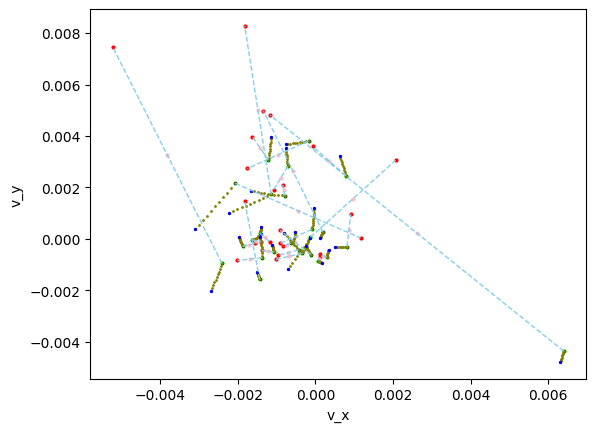

5


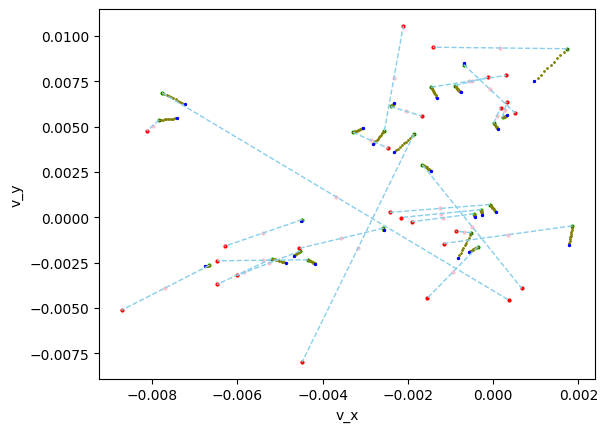

10


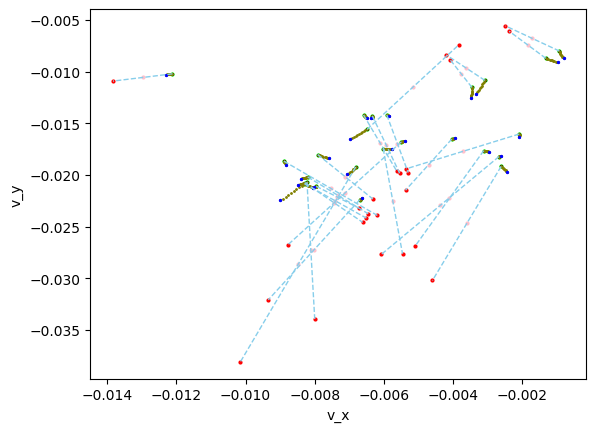

15


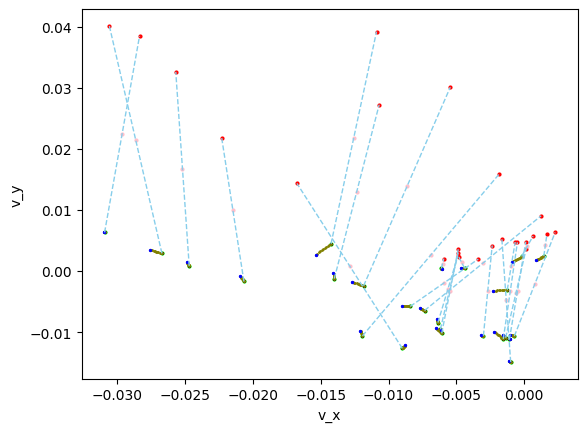

20


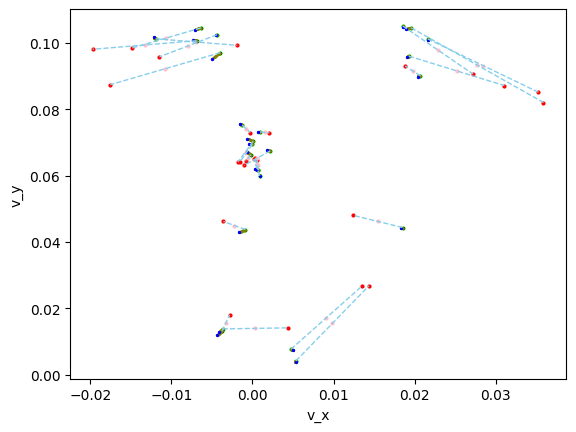

25


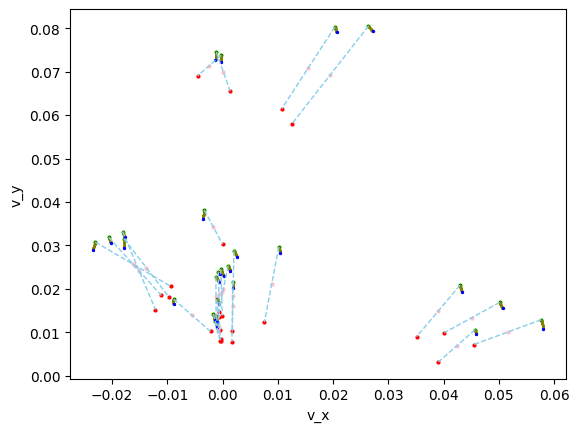

30


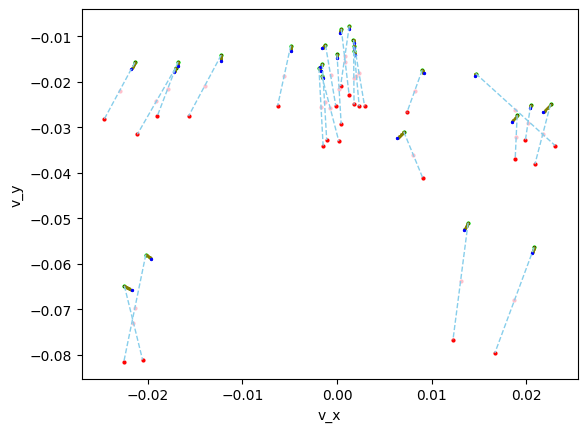

35


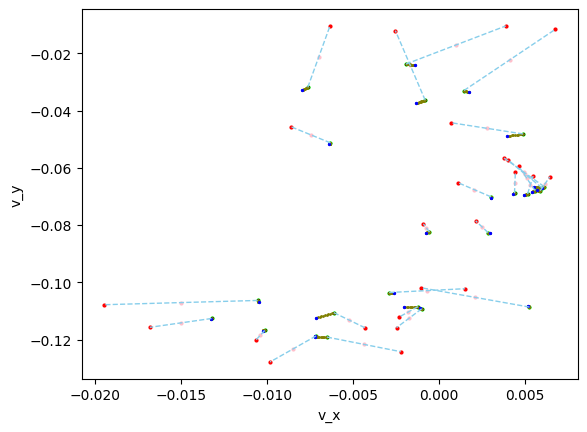

40


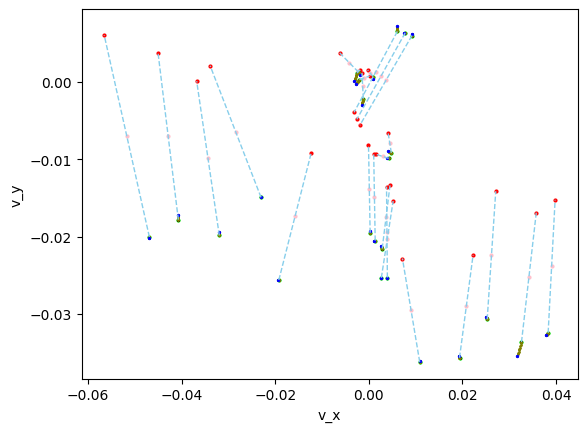

45


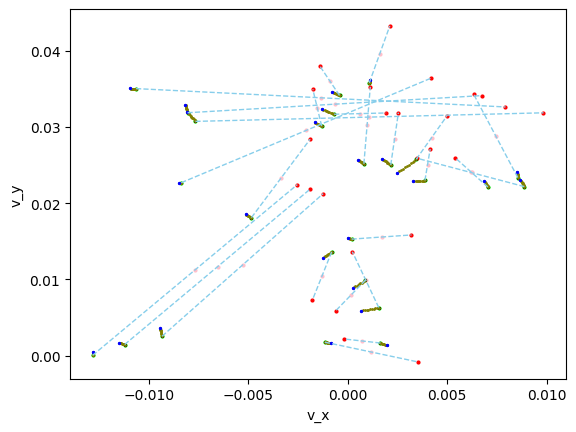

50


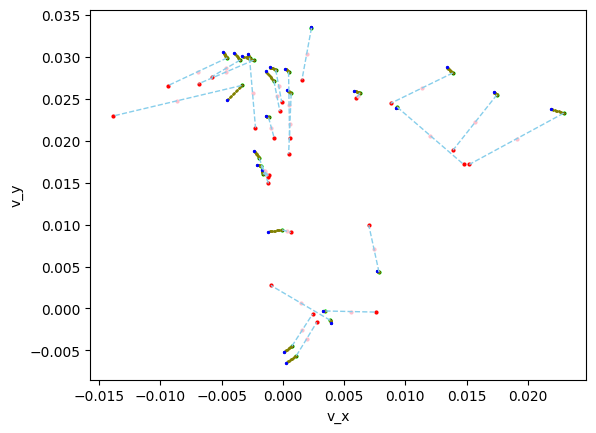

55


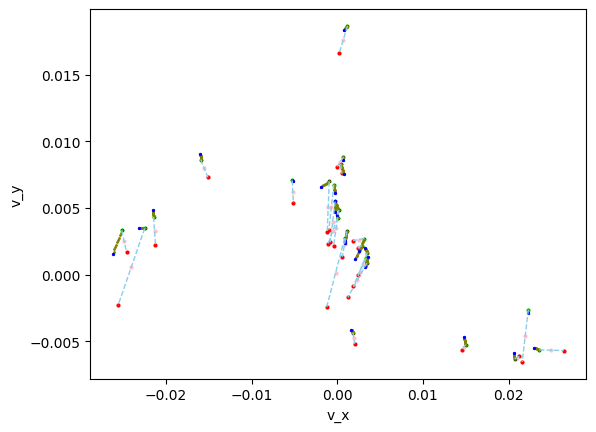

  0%|          | 0/287 [00:25<?, ?it/s]



In [4]:
n_samples = 1

results = []
count = 0
model.eval()
for batch in tqdm(iter(dataloader), total=len(dataset)):
    x, seq_lens, labels = batch
    if labels[0] != 27:
        continue
    x = x.to(device)
    labels = labels.to(device)
    batch = (x, seq_lens, labels)
    results += model.predict_step(batch, None, 10)
    count += 1
    if count == n_samples:
        break

In [5]:
edge = [
    [1, 2],
    [1, 2],
]
connecting_joint = [
    2,
    1,
    21,
    3,
    21,
    5,
    6,
    7,
    21,
    9,
    10,
    11,
    1,
    13,
    14,
    15,
    1,
    17,
    18,
    19,
    2,
    8,
    8,
    12,
    12,
]


def plot_skeleton_nturgbd_each(points, ax, t, x, y, z, c):
    ax.scatter(
        points[t, :, x],
        points[t, :, y],
        points[t, :, z],
        color=c,
    )

    for i in range(len(connecting_joint)):
        j = connecting_joint[i] - 1

        joint_line = plt3d.art3d.Line3D(
            [points[t, i, x], points[t, j, x]],
            [points[t, i, y], points[t, j, y]],
            [points[t, i, z], points[t, j, z]],
            linestyle=":",
            color=c,
        )

        ax.add_line(joint_line)

    return ax


def plot_skeleton_nturgbd(points_true, points_pred, t, seq_len):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = plt.axes(projection="3d")

    plt.ion()
    fig.show()
    fig.canvas.draw()

    x = 0
    y = 2
    z = 1

    ax.clear()

    # Camera coordinate system
    axis_length = 0.2

    # Subject coordinates
    ax.set_xlim3d(
        min(np.amin(points_true[:, :, x]), -axis_length),
        max(np.amax(points_true[:, :, x]), axis_length),
    )
    ax.set_ylim3d(
        min(np.amin(points_true[:, :, y]), -axis_length),
        max(np.amax(points_true[:, :, y]), axis_length),
    )
    ax.set_zlim3d(
        min(np.amin(points_true[:, :, z]), -axis_length),
        max(np.amax(points_true[:, :, z]), axis_length),
    )

    # ax = plot_skeleton_nturgbd_each(points_true, ax, t + 1, x, y, z, "skyblue")
    # ax = plot_skeleton_nturgbd_each(points_true, ax, t + seq_len, x, y, z, "blue")

    # ax = plot_skeleton_nturgbd_each(points_pred[:, 0], ax, t, x, y, z, "pink")
    # ax = plot_skeleton_nturgbd_each(points_pred[:, -1], ax, t, x, y, z, "red")

    ax = plot_skeleton_nturgbd_each(points_true, ax, t, x, y, z, "blue")
    ax = plot_skeleton_nturgbd_each(points_pred, ax, t, x, y, z, "red")

    ax.view_init(10, 50)
    ax.set_axis_off()
    fig.canvas.draw()

    plt.show()

In [6]:
result = results[0]
result["v_pred"].shape

(58, 25, 3)

0


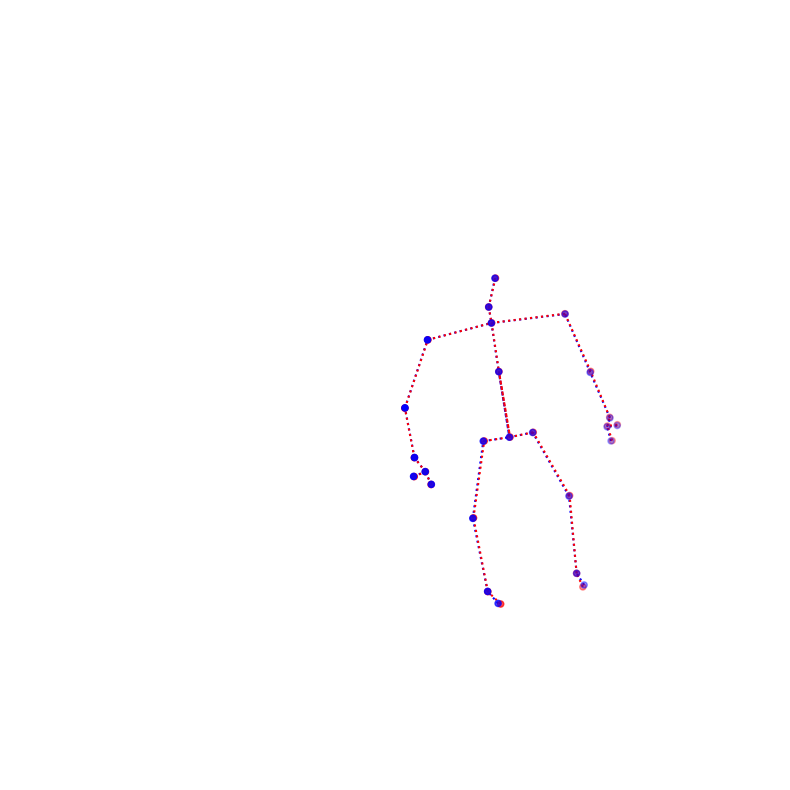

5


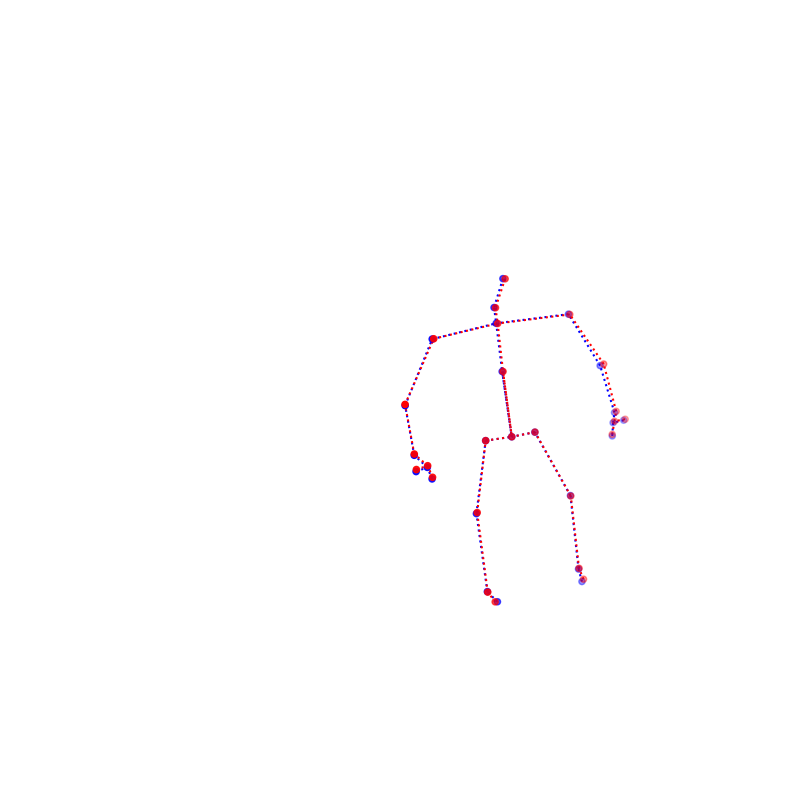

10


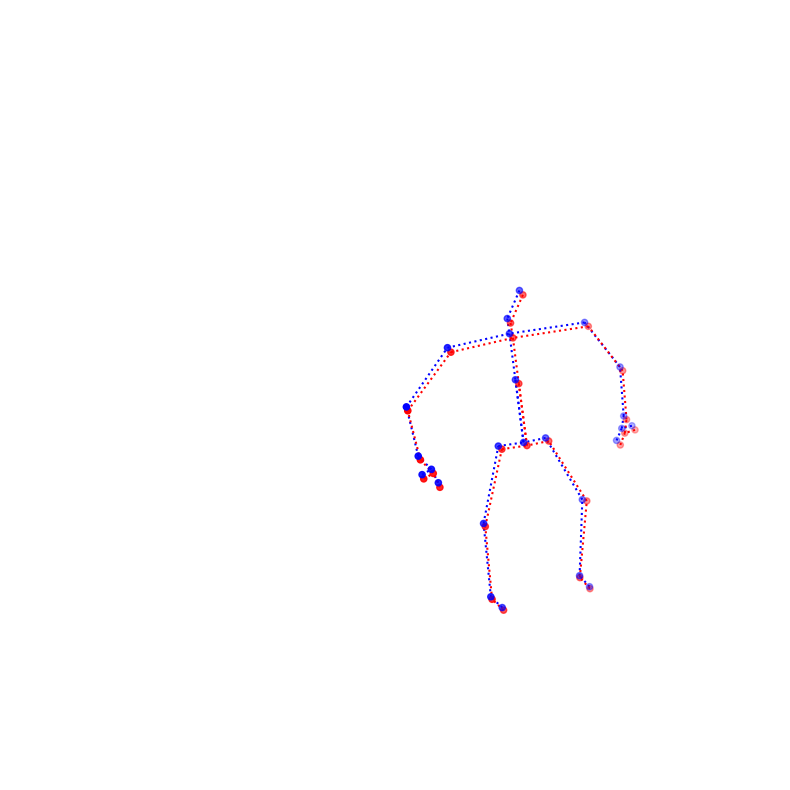

15


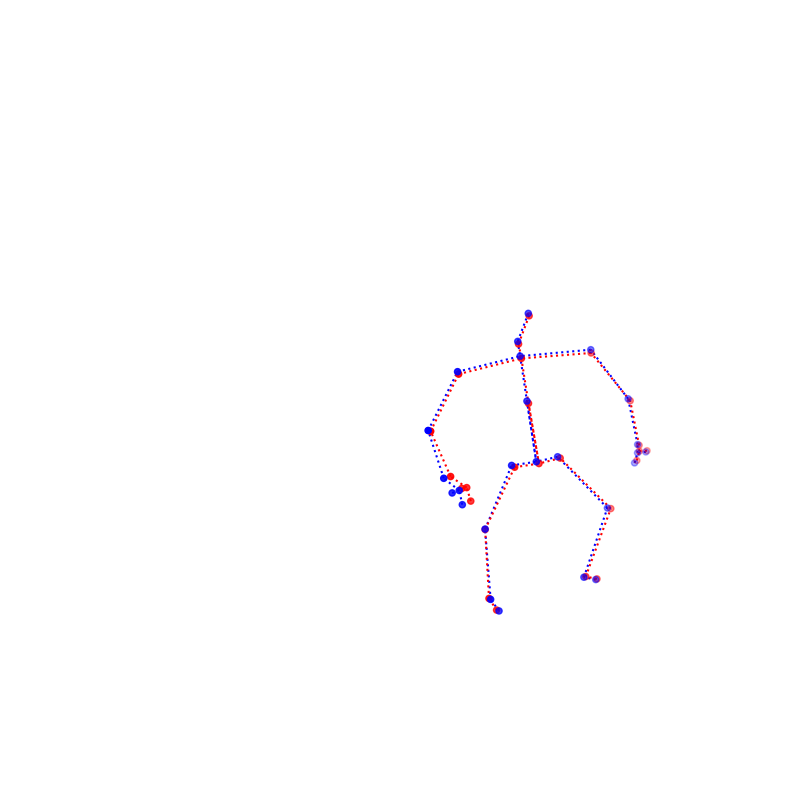

20


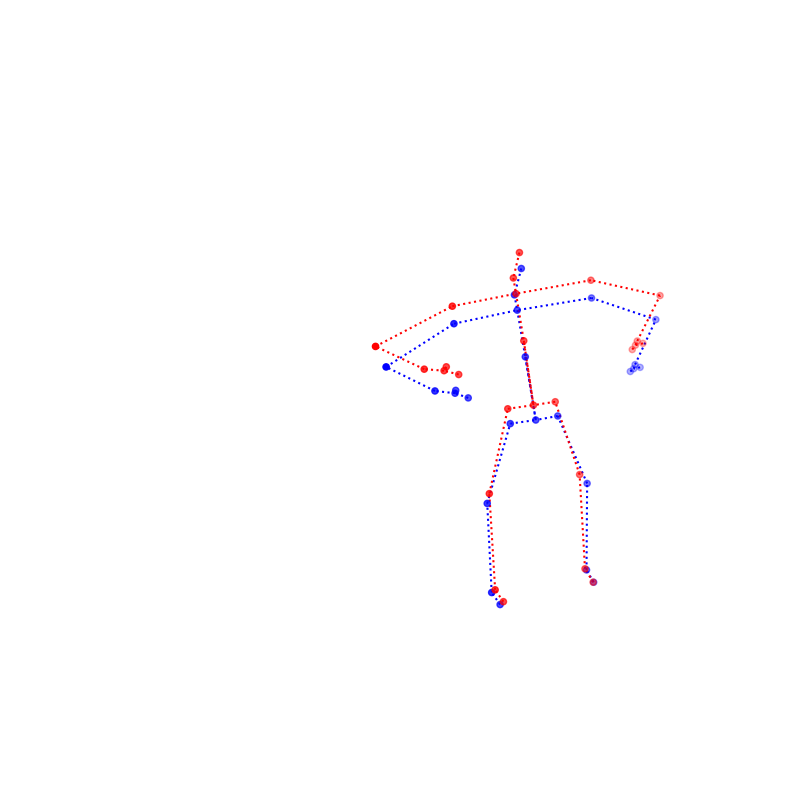

25


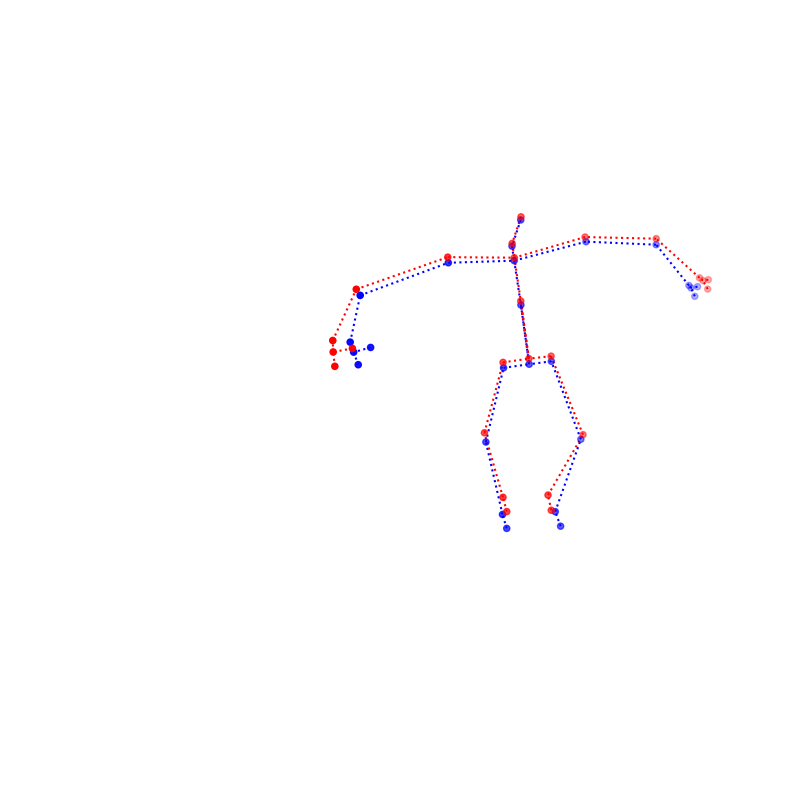

30


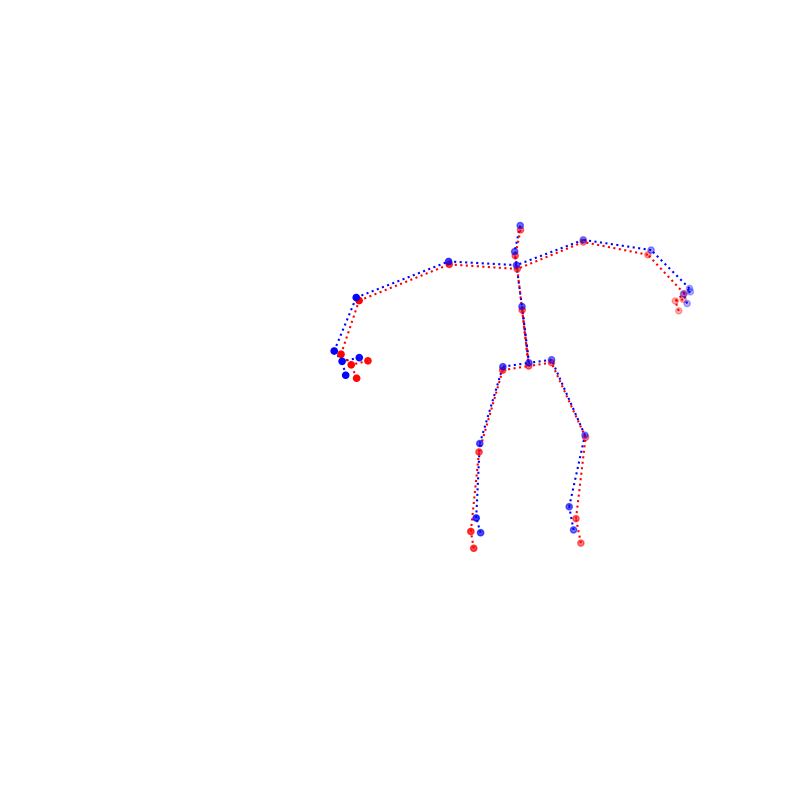

35


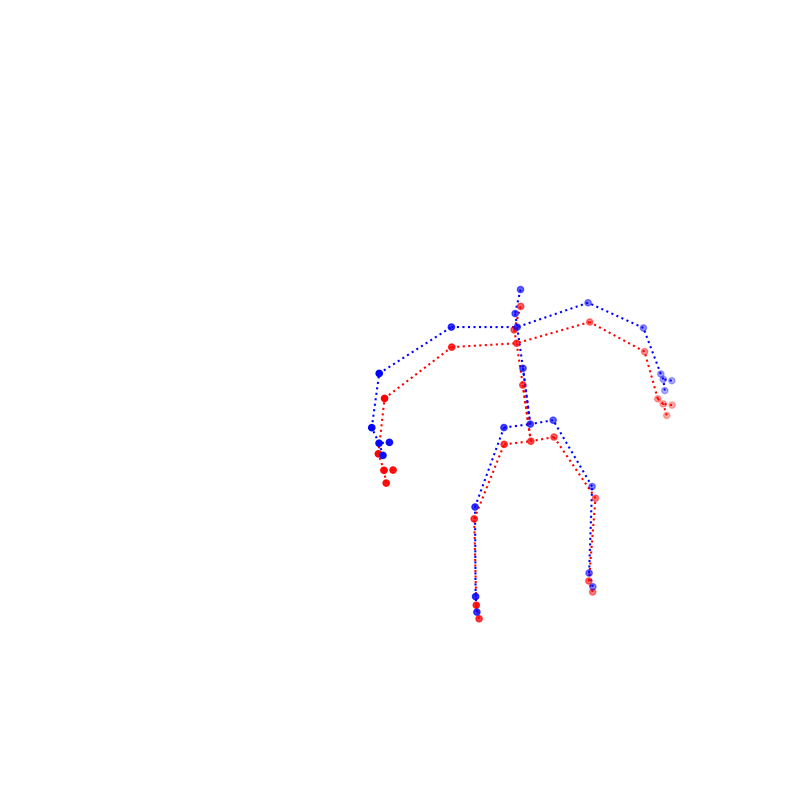

40


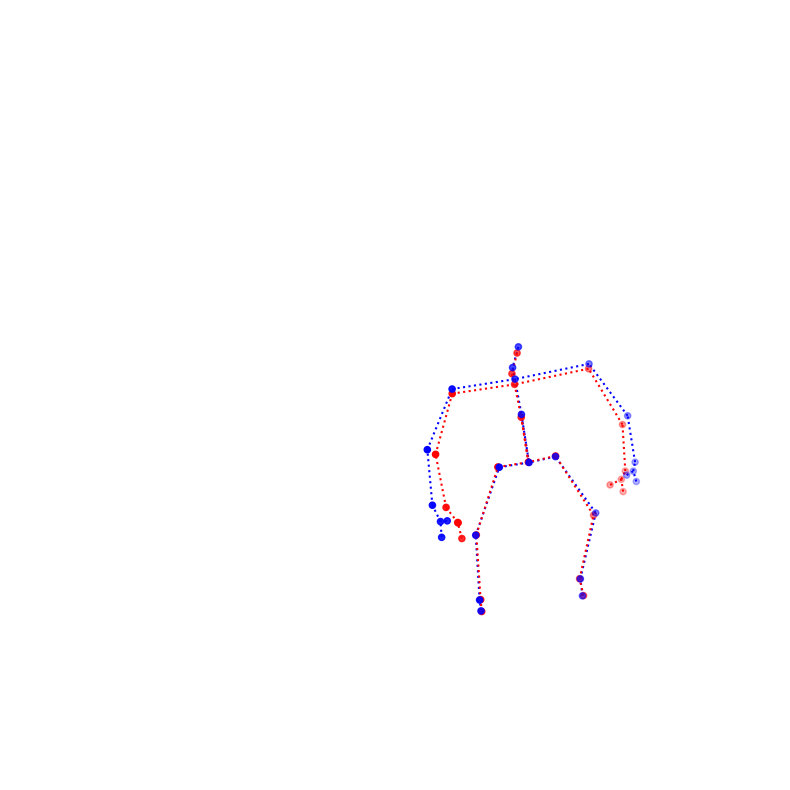

45


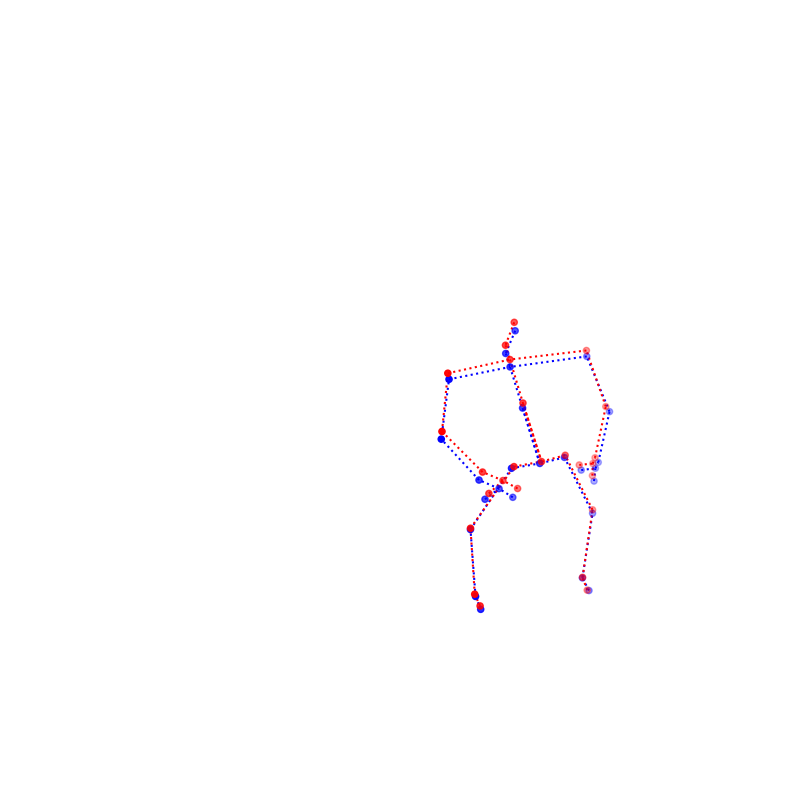

50


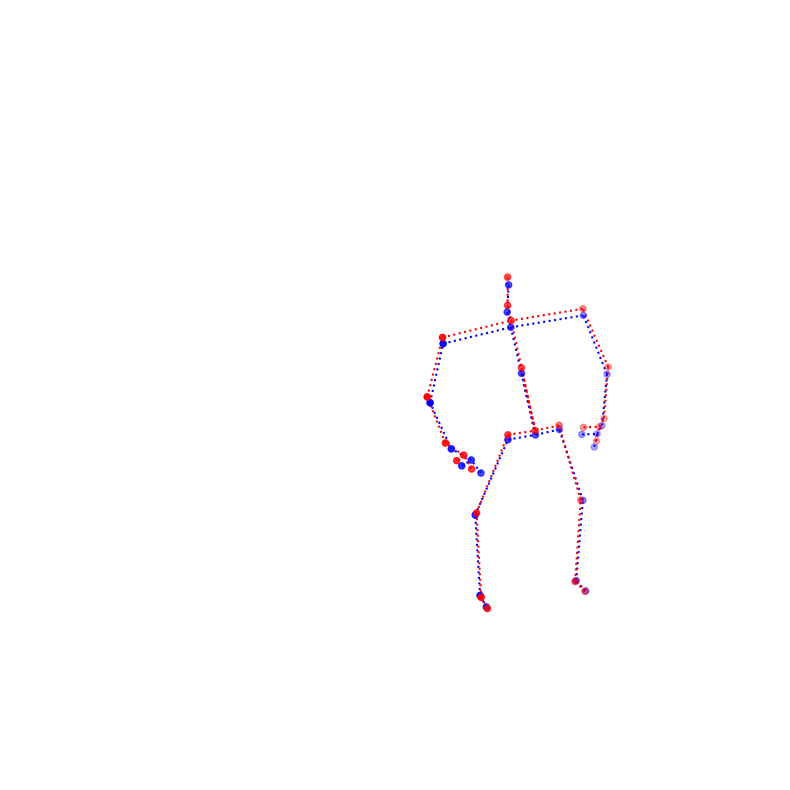

55


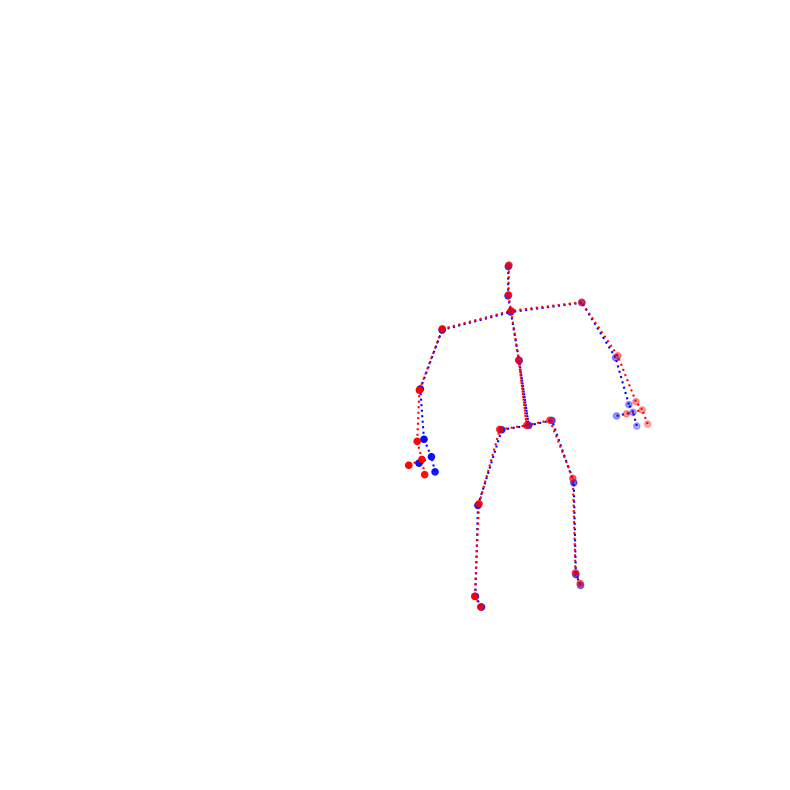

In [7]:
result = results[0]
for t in range(0, result["x_true"].shape[0] - 1, 5):
    print(t)
    plot_skeleton_nturgbd(result["x_true"], result["x_pred"], t, None)

26


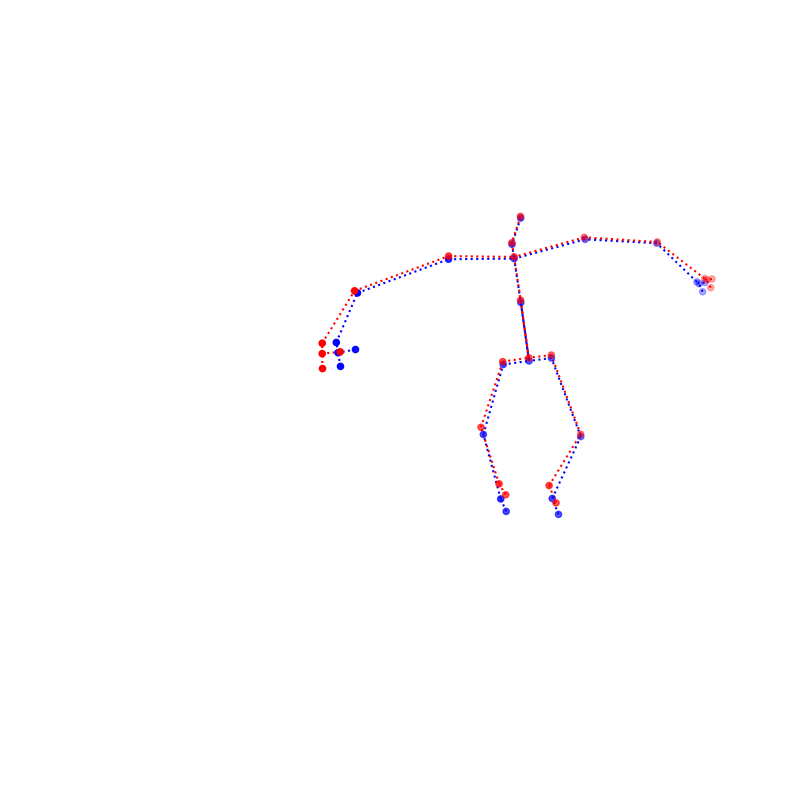

In [11]:
t = 26
print(t)
plot_skeleton_nturgbd(result["x_true"], result["x_pred"], t, None)